# Check modification of step 3 of PTE analysis

Christoph Braun, KIT

There are very minor quantitative differences in the final results. I classify these as acceptable.

In [1]:
exp='channel_2km_0004'
dt = 6
data_res  = '1x1latlon'
#data_res  = '0p05x0p05latlon'
if   dt == 1:
     data_dt = '1hrly'
elif dt == 6:
     data_dt = '6hrly'
        
p2level=50

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import psutil
import datetime
import time as tm
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings("ignore")

In [3]:
#####################################################
# Read in track data from file
#####################################################
#Cyclone Track
#path_track = '/scratch/b/b380782/check_remapping_on_PTE/channel_2km_0004/PTE_out/cyclone_tracks/'
path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'
#path_track = '/work/bb1152/Module_A/A6_CyclEx/b382037_TingChen/Task3/PTE/cyclone_tracks/'

df_track = pd.read_csv(path_track+'Track_for_'+exp+'_'+str(dt)+'hrly_1x1latlon.csv')
#df_track = pd.read_csv(path_track+'Track_for_'+exp+'_'+str(dt)+'hrly_0p05x0p05latlon.csv')

# get timesteps from map
#tmin = time.min()
#tmax = time.max()

# select timesteps from track
#df_track = df_track.loc[(df_track['time']>=tmin) & (df_track['time']<=tmax)]

# determine timesteps of track
ntrack = len(df_track['lat'])

track_dur  = df_track['time']
track_lon  = df_track['lon']
track_lat  = df_track['lat']
    
df_track

Unnamed: 0  time         pmin   lon   lat
0            0  0.00  1000.991638  56.5  27.5
1            1  0.25   997.934448  61.5  23.5
2            2  0.50   998.462646  21.5  42.5
3            3  0.75   997.014771  32.5  28.5
4            4  1.00   999.559631  27.5  42.5
5            5  1.25   997.670227  27.5  43.5
6            6  1.50   998.062012  31.5  44.5
7            7  1.75   997.686157  40.5  42.5
8            8  2.00   997.231018  45.5  44.5
9            9  2.25   995.639587  49.5  43.5
10          10  2.50   993.030029  52.5  44.5
11          11  2.75   988.784302  56.5  44.5
12          12  3.00   985.596008  59.5  45.5
13          13  3.25   981.169678  14.5  45.5
14          14  3.50   976.026123  17.5  46.5
15          15  3.75   970.745728  19.5  46.5
16          16  4.00   967.672241  23.5  47.5
17          17  4.25   966.600647  28.5  47.5
18          18  4.50   963.127014  34.5  48.5
19          19  4.75   961.268616  37.5  48.5
20          20  5.00   960.033142  42.5  49.5
21          21  5.25   959.165527  46.5  49.5
22          22  5.50   954.482788  54.5  50.5
23          23  5.75   950.702515  60.5  50.5
24          24  6.00   944.416199  13.5  51.5
25          25  6.25   939.254089  14.5  51.5
26          26  6.50   943.386414  15.5  50.5
27          27  6.75   944.307129  23.5  52.5
28          28  7.00   945.061279  28.5  53.5
29          29  7.25   945.369507  34.5  52.5
30          30  7.50   945.417725  34.5  53.5
31          31  7.75   945.800781  39.5  53.5
32          32  8.00   948.895386  39.5  53.5
33          33  8.25   952.656189  45.5  53.5
34          34  8.50   955.252869  55.5  50.5
35          35  8.75   962.483459  54.5  51.5
36          36  9.00   963.767273  24.5  46.5

In [4]:
import xarray as xr

In [5]:
ipath = '/work/bb1152/Module_A/A6_CyclEx/b380782_Christoph/temp_PTE_out/PTE/maps/'
#ipath = '/work/bb1152/Module_A/A6_CyclEx/pp_data/PTE_maps/'

#ifile = "PTE_map_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(int(p2level))+"hPa.nc"
ifile = "PTE_map_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(int(p2level))+"hPa_day*.nc"


# read the data
data_file= ipath+ifile

In [6]:
ds = xr.open_mfdataset(data_file)

In [7]:
ds_vars = list(ds.keys())
lon_cen = ds.lon[int(ds.lon.size/2)]
dlon = 1
#dlon = 0.05
boxsize = 6

In [8]:
def get_boxmean(ds):
    
    weights = np.cos(np.deg2rad(ds.lat))
    ds_mean = ds.weighted(weights=weights).mean(dim=['lat','lon'])
    
    return ds_mean

In [9]:
for var in ds_vars:
    df_track[var] = pd.Series()

In [10]:
for ftime in ds.time:
    ds_temp = ds.sel(time=ftime)
    
    # get index of panda dataframe fitting current timestep
    itime_df = float(df_track.index[df_track['time']==float(ftime)].values)
    
    lon_pmin = df_track['lon'][itime_df]
    lat_pmin = df_track['lat'][itime_df]
    
    lon_to_roll = int((lon_cen - lon_pmin)/dlon)
    #print(lon_to_roll)
    
    ds_temp['lon'] = ds_temp['lon']-lon_cen
    
    ds_box = ds_temp.roll(shifts={'lon':lon_to_roll}).sel(lat=slice(lat_pmin-boxsize/2,lat_pmin+boxsize/2),lon=slice(-boxsize/2,boxsize/2))
    #ds_box.mslp.plot.pcolormesh()
    #plt.show()
    ds_boxmean = get_boxmean(ds_box)
    for var in ds_vars:
        df_track[var][itime_df] = float(ds_boxmean[var].values)/100

In [11]:
df_track

Unnamed: 0  time         pmin   lon   lat        mslp   dpsfc_dt   
0            0  0.00  1000.991638  56.5  27.5         NaN        NaN  \
1            1  0.25   997.934448  61.5  23.5         NaN        NaN   
2            2  0.50   998.462646  21.5  42.5         NaN        NaN   
3            3  0.75   997.014771  32.5  28.5         NaN        NaN   
4            4  1.00   999.559631  27.5  42.5         NaN        NaN   
5            5  1.25   997.670227  27.5  43.5         NaN        NaN   
6            6  1.50   998.062012  31.5  44.5         NaN        NaN   
7            7  1.75   997.686157  40.5  42.5  997.960469  -1.528532   
8            8  2.00   997.231018  45.5  44.5  997.782266  -1.064874   
9            9  2.25   995.639587  49.5  43.5    996.2725  -2.315292   
10          10  2.50   993.030029  52.5  44.5  994.170234  -2.972349   
11          11  2.75   988.784302  56.5  44.5  990.658906  -5.030021   
12          12  3.00   985.596008  59.5  45.5  988.819922  -3.317254   
13          13  3.25   981.169678  14.5  45.5  986.357344  -5.949769   
14          14  3.50   976.026123  17.5  46.5  982.967266  -6.545591   
15          15  3.75   970.745728  19.5  46.5  978.919062  -4.308632   
16          16  4.00   967.672241  23.5  47.5  975.420391  -3.763589   
17          17  4.25   966.600647  28.5  47.5  971.898516  -3.444295   
18          18  4.50   963.127014  34.5  48.5  968.725547  -5.224357   
19          19  4.75   961.268616  37.5  48.5  966.840078  -2.697195   
20          20  5.00   960.033142  42.5  49.5  965.723984  -3.248944   
21          21  5.25   959.165527  46.5  49.5  963.251406  -3.423848   
22          22  5.50   954.482788  54.5  50.5  960.745625  -8.634359   
23          23  5.75   950.702515  60.5  50.5  956.412891 -11.277213   
24          24  6.00   944.416199  13.5  51.5  953.267812 -10.513564   
25          25  6.25   939.254089  14.5  51.5  949.747031  -4.175635   
26          26  6.50   943.386414  15.5  50.5      952.24   4.132575   
27          27  6.75   944.307129  23.5  52.5  949.676719  -3.798563   
28          28  7.00   945.061279  28.5  53.5  951.351328  -4.223829   
29          29  7.25   945.369507  34.5  52.5  949.983047  -7.115826   
30          30  7.50   945.417725  34.5  53.5  951.252813  -0.704494   
31          31  7.75   945.800781  39.5  53.5  951.946406  -2.020101   
32          32  8.00   948.895386  39.5  53.5  955.078281   3.131887   
33          33  8.25   952.656189  45.5  53.5  958.661719   1.878386   
34          34  8.50   955.252869  55.5  50.5  962.395781   0.550036   
35          35  8.75   962.483459  54.5  51.5  967.968672   4.417296   
36          36  9.00   963.767273  24.5  46.5  968.786562  -2.618322   

      dfi_dt        EP        ITT    Eq1res       TADV        VMT   DIABres  
0        NaN       NaN        NaN       NaN        NaN        NaN       NaN  
1        NaN       NaN        NaN       NaN        NaN        NaN       NaN  
2        NaN       NaN        NaN       NaN        NaN        NaN       NaN  
3        NaN       NaN        NaN       NaN        NaN        NaN       NaN  
4        NaN       NaN        NaN       NaN        NaN        NaN       NaN  
5        NaN       NaN        NaN       NaN        NaN        NaN       NaN  
6        NaN       NaN        NaN       NaN        NaN        NaN       NaN  
7  -1.410422 -0.001115  -0.113506  -0.00349  -3.250336   0.124568  3.012262  
8  -3.222407 -0.015798   2.413954 -0.240624  -5.094301   1.223247  6.285009  
9  -1.436804 -0.053651  -0.899242  0.074405  -4.800681   3.946058 -0.044619  
10 -0.213752 -0.116417  -2.771031  0.128852  -5.994471   7.113004 -3.889565  
11 -3.906765 -0.196581  -1.021318  0.094642  -7.971294   7.949547 -0.999571  
12 -1.654068 -0.266696  -1.545979   0.14949  -9.712738   8.732941 -0.566181  
13   1.65093 -0.427943  -7.510536  0.337782 -15.538982  14.034597 -6.006152  
14  0.411215 -0.523898  -6.928629  0.495721 -18.411635  18.481935  -6.99893  
15 -3.457062 -0.498

Load original data

In [12]:
df_track_orig = pd.read_csv('/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_PTE_timeseries/PTE_for_channel_2km_0004_6hrly_1x1latlon_upper50hPa_box6.csv')


In [13]:
df_track_orig

Unnamed: 0.1  Unnamed: 0  time         pmin   lon   lat         dp   
0              0           0  0.00  1000.991638  56.5  27.5        NaN  \
1              1           1  0.25   997.934448  61.5  23.5        NaN   
2              2           2  0.50   998.462646  21.5  42.5        NaN   
3              3           3  0.75   997.014771  32.5  28.5        NaN   
4              4           4  1.00   999.559631  27.5  42.5        NaN   
5              5           5  1.25   997.670227  27.5  43.5        NaN   
6              6           6  1.50   998.062012  31.5  44.5        NaN   
7              7           7  1.75   997.686157  40.5  42.5  -1.524770   
8              8           8  2.00   997.231018  45.5  44.5  -1.069876   
9              9           9  2.25   995.639587  49.5  43.5  -2.321588   
10            10          10  2.50   993.030029  52.5  44.5  -2.990081   
11            11          11  2.75   988.784302  56.5  44.5  -5.055136   
12            12          12  3.00   985.596008  59.5  45.5  -3.353602   
13            13          13  3.25   981.169678  14.5  45.5  -5.994007   
14            14          14  3.50   976.026123  17.5  46.5  -6.623694   
15            15          15  3.75   970.745728  19.5  46.5  -4.369829   
16            16          16  4.00   967.672241  23.5  47.5  -3.810261   
17            17          17  4.25   966.600647  28.5  47.5  -3.476231   
18            18          18  4.50   963.127014  34.5  48.5  -5.311000   
19            19          19  4.75   961.268616  37.5  48.5  -2.719412   
20            20          20  5.00   960.033142  42.5  49.5  -3.278760   
21            21          21  5.25   959.165527  46.5  49.5  -3.416591   
22            22          22  5.50   954.482788  54.5  50.5  -8.724039   
23            23          23  5.75   950.702515  60.5  50.5 -11.366186   
24            24          24  6.00   944.416199  13.5  51.5 -10.644620   
25            25          25  6.25   939.254089  14.5  51.5  -4.240595   
26            26          26  6.50   943.386414  15.5  50.5   4.205340   
27            27          27  6.75   944.307129  23.5  52.5  -3.898076   
28            28          28  7.00   945.061279  28.5  53.5  -4.344801   
29            29          29  7.25   945.369507  34.5  52.5  -7.236033   
30            30          30  7.50   945.417725  34.5  53.5  -0.751102   
31            31          31  7.75   945.800781  39.5  53.5  -2.111114   
32            32          32  8.00   948.895386  39.5  53.5   3.091955   
33            33          33  8.25   952.656189  45.5  53.5   1.786963   
34            34          34  8.50   955.252869  55.5  50.5   0.464534   
35            35          35  8.75   962.483459  54.5  51.5   4.338640   
36            36          36  9.00   963.767273  24.5  46.5  -2.708739   

         dfi        ep        itt    eq1res       tadv        vmt       diab   
0        NaN       NaN        NaN       NaN        NaN        NaN        NaN  \
1        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
2        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
3        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
4        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
5        NaN       NaN        NaN       NaN        NaN        NaN        NaN   
6        NaN       NaN   0.000000       NaN        NaN        NaN        NaN   
7  -1.383483       NaN  -0.139179       NaN  -3.278262   0.135743   2.536982   
8  -3.226608 -0.015867   2.412867 -0.240268  -5.108050   1.300298   3.947564   
9  -1.431471 -0.054107  -0.911131  0.075121  -4.832134   3.987414   0.976318   
10 -0.227541 -0.115441  -2.774673  0.127574  -6.031978   7.124756  -1.840393   
11 -3.907526 -0.194425  -1.048631  0.095447  -8.037870   7.918819  -1.064185   
12 -1.661278 -0.264434  -1.574067  0.146178  -9.813810   8.754335  -0.396583   
13  1.667370 -0.424664  -7.574016  0.337304 -15.649766  14.116293  -5.6

Compare single coordinates for sanity

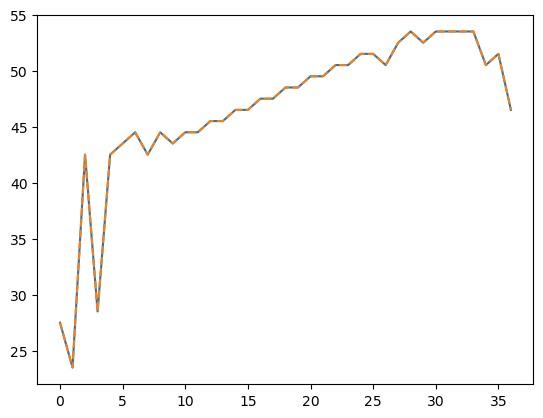

In [14]:
plt.plot(df_track['lat'])
plt.plot(df_track_orig['lat'],ls='--')

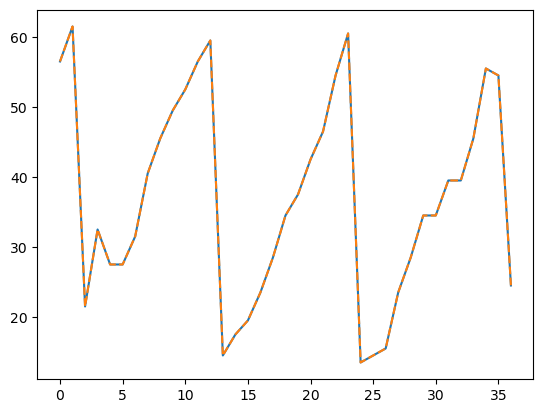

In [15]:
plt.plot(df_track['lon'])
plt.plot(df_track_orig['lon'],ls='--')

Compare variables

In [17]:
keys = list(df_track.keys()[6:])

In [18]:
keys

['dpsfc_dt', 'dfi_dt', 'EP', 'ITT', 'Eq1res', 'TADV', 'VMT', 'DIABres']

In [19]:
keys_orig = list(df_track_orig.keys()[6:-5])

In [20]:
keys_orig.append(df_track_orig.keys()[-3])

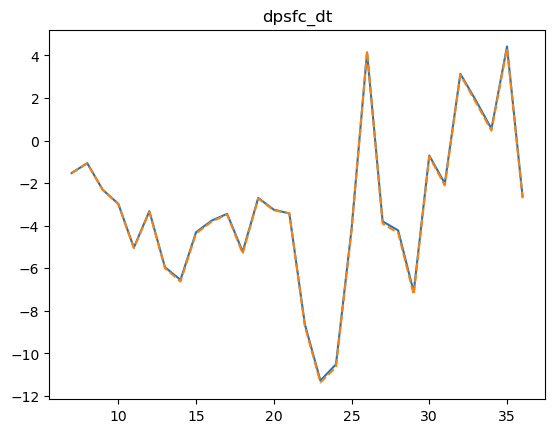

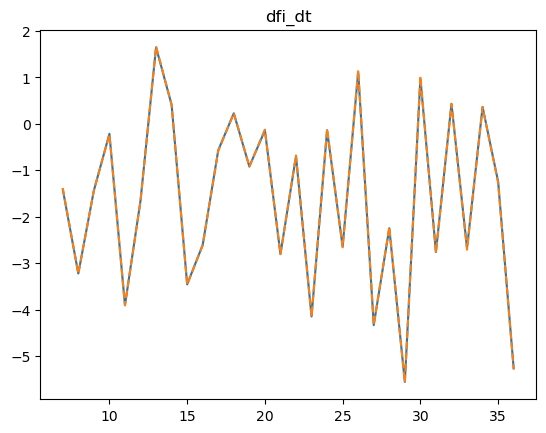

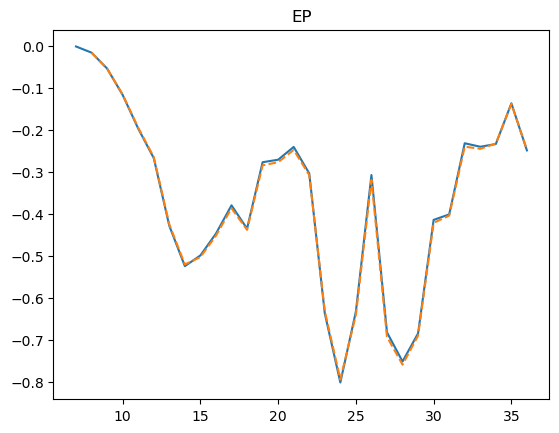

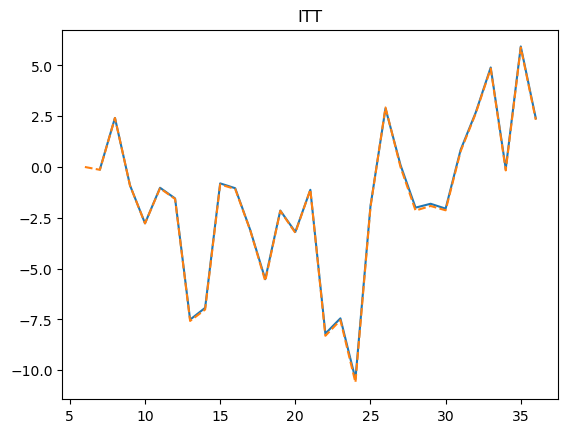

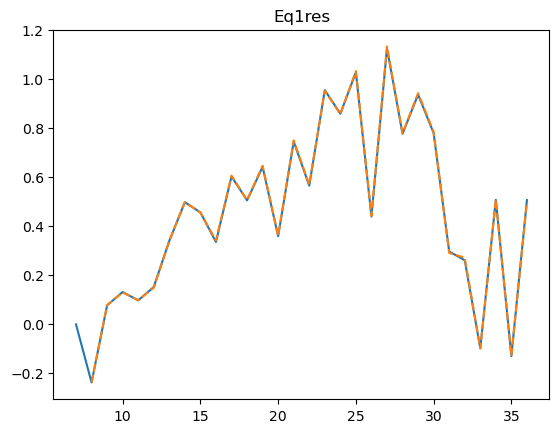

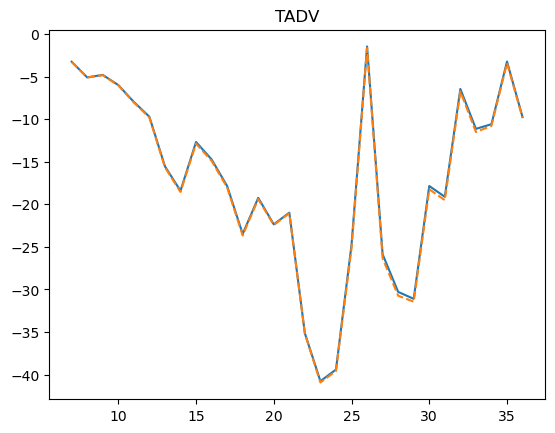

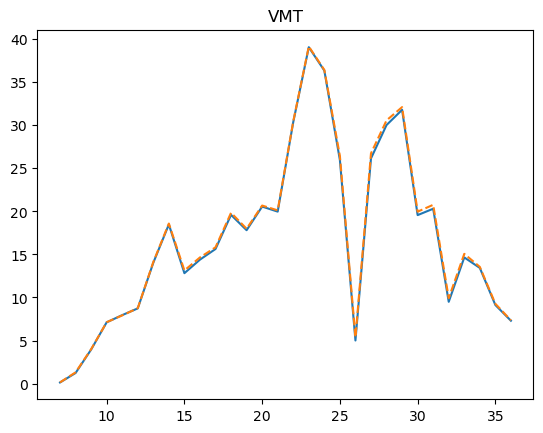

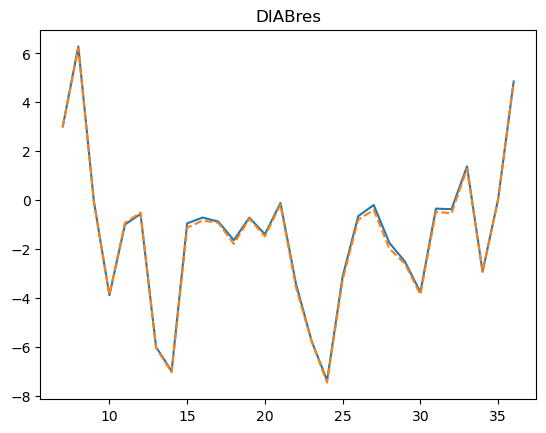

In [21]:
for key,key_orig in zip(keys,keys_orig):
    plt.plot(df_track[key])
    plt.plot(df_track_orig[key_orig],ls='--')
    plt.title(key)
    plt.show()

#### 